In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import datasets, manifold, neighbors
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
import gtda.graphs as gtg

In [3]:
n_points = 1000
graph_type = 'knn'

Text(0.5, 1.0, 'Circles')

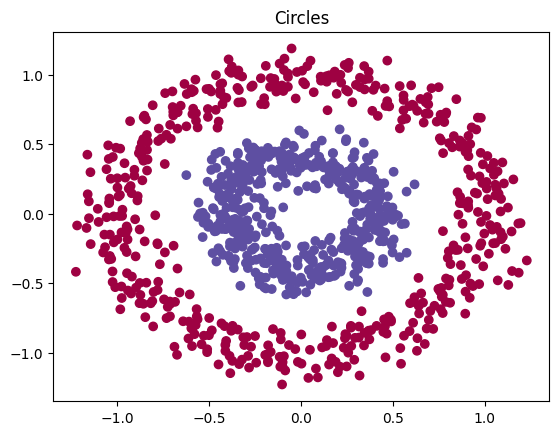

In [4]:
# make swiss roll
X, color = datasets.make_circles(n_samples=n_points, factor=.4, noise=.1)

# plot swiss roll
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Circles")

/home/tristan/envs/orcml/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Text(0.5, 1.0, 'G in original space')

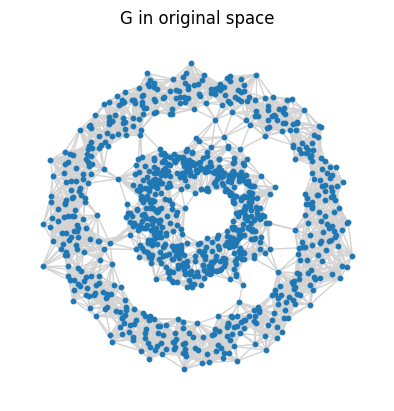

In [5]:
# construct nearest neighbor graph

n_neighbors = 20
if graph_type == 'radius':
    knn = neighbors.radius_neighbors_graph(X, 0.1, mode='distance')
else:
    knn = neighbors.kneighbors_graph(X, n_neighbors, mode='distance')

# convert to networkx graph
G = nx.Graph()
for i in range(n_points):
    for j in range(i+1, n_points):
        if knn[i, j] > 0:
            G.add_edge(i, j, weight=knn[i, j])

# plot nearest neighbor graph in original space
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
# get nodelist
nodelist = nx.nodes(G)
nx.draw(G, pos=X, node_size=10, ax=ax, edge_color='lightgrey', cmap=plt.cm.Spectral)
plt.title("G in original space")

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


Text(0.5, 1.0, 'Spectral embedding using G')

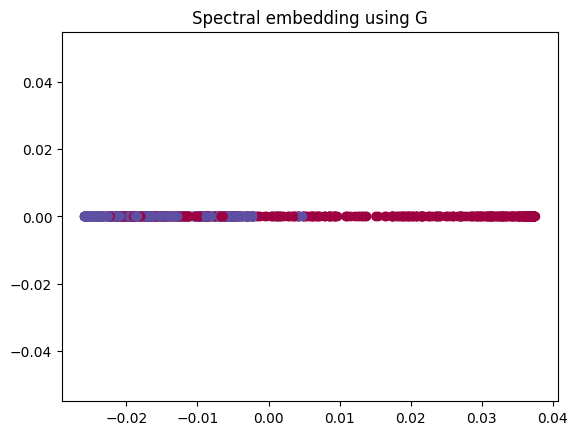

In [6]:
# run spectral embedding
n_components = 1
se = manifold.SpectralEmbedding(n_components=n_components, affinity='precomputed')
Y = se.fit_transform(knn)

# plot spectral embedding
fig = plt.figure()
ax = fig.add_subplot(111)
if n_components == 1:
    ax.scatter(Y, np.zeros(n_points), c=color, cmap=plt.cm.Spectral)
else:
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Spectral embedding using G")

/tmp/ipykernel_65555/3915815836.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


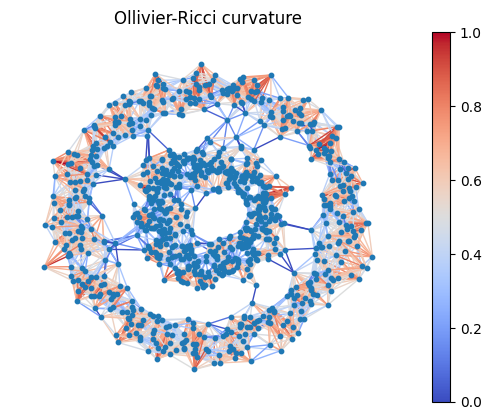

In [7]:
# use edge weights
orc = OllivierRicci(G, weight="weight", alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()

# fetch ollivier-ricci curvature
orcs = []
for i, j, d in orc.G.edges(data=True):
    orcs.append(orc.G[i][j]['ricciCurvature'])

# clamp orc's such that they lie within 2 standard deviations of the mean
orcs = np.array(orcs)
mean = np.mean(orcs)
std = np.std(orcs)

adjusted_orcs = np.clip(orcs, mean - 2*std, mean + 2*std)
# map to 0-1
adjusted_orcs = (adjusted_orcs - adjusted_orcs.min()) / (adjusted_orcs.max() - adjusted_orcs.min())

# reassign orc's to graph
for idx, (i, j, d) in enumerate(orc.G.edges(data=True)):
    d['ricciCurvature'] = adjusted_orcs[idx]

# # plot ollivier-ricci curvature
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(orc.G, pos=X, node_size=10, ax=ax, edge_color=adjusted_orcs, edge_cmap=plt.cm.coolwarm , edge_vmin=0, edge_vmax=1)

plt.title("Ollivier-Ricci curvature")
# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
plt.colorbar(sm)
plt.show()

Percentage of edges preserved: 0.7383865512782254


/tmp/ipykernel_65555/1552093919.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


Text(0.5, 1.0, 'Pruned graph')

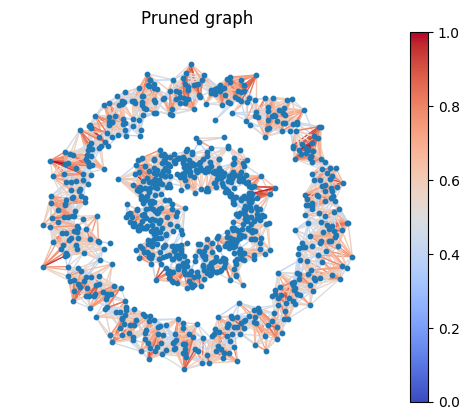

In [8]:
threshold = 0.4

G_pruned = nx.Graph()
preserved_nodes = set()
for i, j, d in orc.G.edges(data=True):
    if d['ricciCurvature'] > threshold:
        G_pruned.add_edge(i, j, weight=d['weight'])
        preserved_nodes.add(i)
        preserved_nodes.add(j)
        # add edge attribute
        G_pruned[i][j]['ricciCurvature'] = d['ricciCurvature']
        
X_pruned = X[list(preserved_nodes)]
color_pruned = color[list(preserved_nodes)]
print(f'Percentage of edges preserved: {len(G_pruned.edges) / len(G.edges)}')

preserved_orcs = []
for i, j, d in G_pruned.edges(data=True):
    preserved_orcs.append(G_pruned[i][j]['ricciCurvature'])

# plot pruned graph
fig = plt.figure()
ax = fig.add_subplot(111)

# get nodelist
nodelist = nx.nodes(G_pruned)
ax.set_aspect('equal')
nx.draw(G_pruned, pos=X, node_size=10, ax=ax, edge_color=preserved_orcs, edge_cmap=plt.cm.coolwarm, edge_vmin=0, edge_vmax=1)
plt.colorbar(sm)
plt.title("Pruned graph")

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


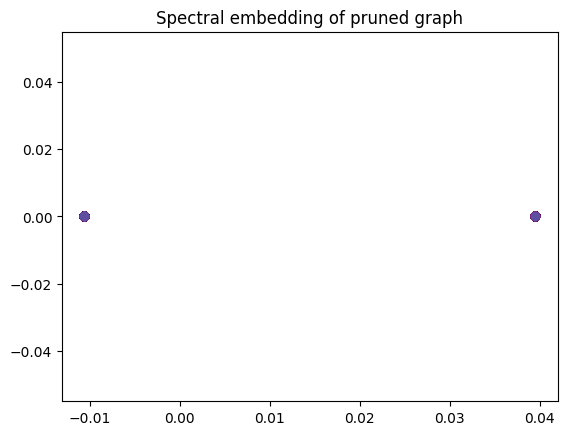

In [9]:
# run spectral embedding
# get adjacency matrix

knn_pruned = nx.adjacency_matrix(G_pruned).toarray()
se = manifold.SpectralEmbedding(n_components=n_components, affinity='precomputed')
Y = se.fit_transform(knn_pruned)

# plot spectral embedding
fig = plt.figure()
ax = fig.add_subplot(111)
if n_components == 1:
    ax.scatter(Y, np.zeros_like(Y), c=color_pruned, cmap=plt.cm.Spectral)
else:
    ax.scatter(Y[:, 0], Y[:, 1], c=color_pruned, cmap=plt.cm.Spectral)
plt.title("Spectral embedding of pruned graph")

plt.show()

Text(0.5, 1.0, 'Swiss roll')

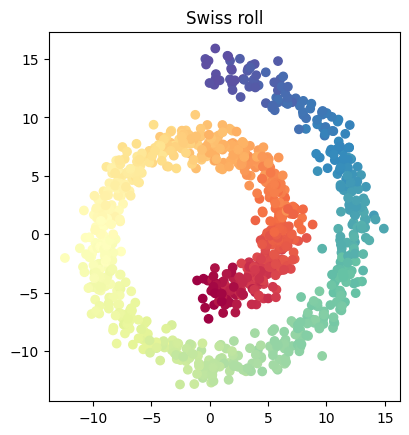

In [10]:
# swiss roll

swiss_roll, color = datasets.make_swiss_roll(n_points, noise=0.9)
# take only the first first, last dimension
swiss_roll = swiss_roll[:, [0, 2]]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], c=color, cmap=plt.cm.Spectral)
ax.set_aspect('equal')
plt.title("Swiss roll")

Text(0.5, 1.0, 'Nearest neighbor graph in original space')

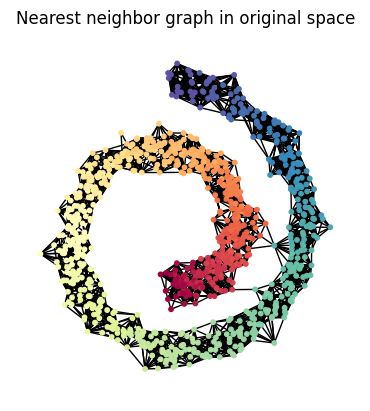

In [11]:
# construct nearest neighbor graph
n_neighbors = 20
knn = neighbors.kneighbors_graph(swiss_roll, n_neighbors, mode='distance')

# convert to networkx graph
G = nx.Graph()
for i in range(n_points):
    for j in range(i+1, n_points):
        if knn[i, j] > 0:
            G.add_edge(i, j, weight=knn[i, j])

# plot nearest neighbor graph in original space
fig = plt.figure()
ax = fig.add_subplot(111)
# get nodelist
nodelist = nx.nodes(G)
ax.set_aspect('equal')
nx.draw(G, pos=swiss_roll, node_size=10, ax=ax, node_color=color[nodelist], cmap=plt.cm.Spectral)
plt.title("Nearest neighbor graph in original space")

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


Text(0.5, 1.0, 'Isomap')

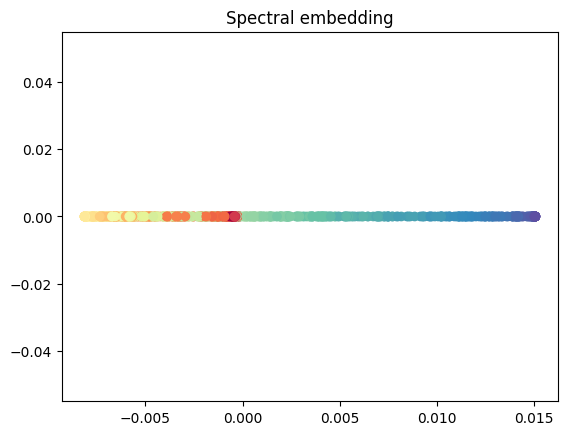

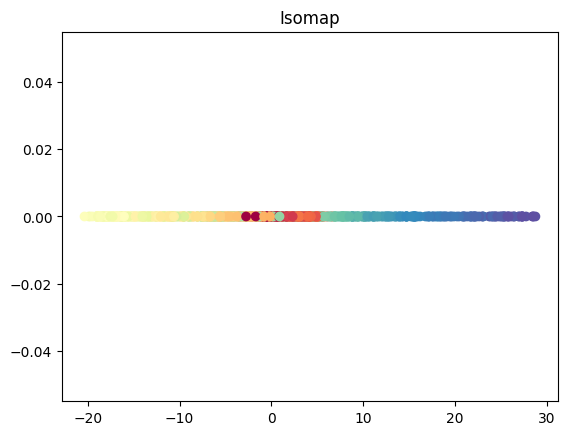

In [12]:
# run spectral embedding
n_components = 1

se = manifold.SpectralEmbedding(n_components=n_components, affinity='precomputed')
Y = se.fit_transform(knn)

# plot spectral embedding
fig = plt.figure()
ax = fig.add_subplot(111)

if n_components == 1:
    ax.scatter(Y, np.zeros(n_points), c=color, cmap=plt.cm.Spectral)
else:
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Spectral embedding")


# run isomap

iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
Y = iso.fit_transform(swiss_roll)

# plot isomap
fig = plt.figure()
ax = fig.add_subplot(111)
if n_components == 1:
    ax.scatter(Y, np.zeros(n_points), c=color, cmap=plt.cm.Spectral)
else:
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap")


/tmp/ipykernel_65555/4088749151.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


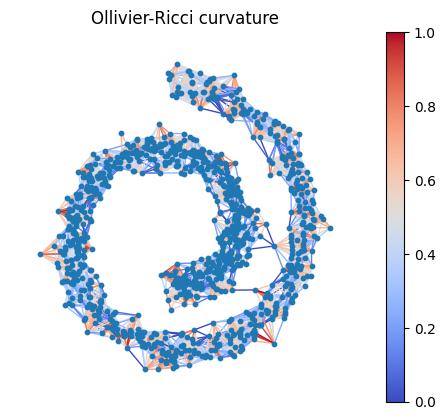

In [13]:
# use edge weights
orc = OllivierRicci(G, weight="weight", alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()

# fetch ollivier-ricci curvature
orcs = []
for i, j, d in orc.G.edges(data=True):
    orcs.append(orc.G[i][j]['ricciCurvature'])

# clamp orc's such that they lie within 2 standard deviations of the mean
orcs = np.array(orcs)
mean = np.mean(orcs)
std = np.std(orcs)

adjusted_orcs = np.clip(orcs, mean - 2*std, mean + 2*std)
# map to 0-1
adjusted_orcs = (adjusted_orcs - adjusted_orcs.min()) / (adjusted_orcs.max() - adjusted_orcs.min())

# reassign orc's to graph
for idx, (i, j, d) in enumerate(orc.G.edges(data=True)):
    d['ricciCurvature'] = adjusted_orcs[idx]

# # plot ollivier-ricci curvature
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
nx.draw(orc.G, pos=swiss_roll, node_size=10, ax=ax, edge_color=adjusted_orcs, edge_cmap=plt.cm.coolwarm , edge_vmin=0, edge_vmax=1)

plt.title("Ollivier-Ricci curvature")
# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
plt.colorbar(sm)
plt.show()

Percentage of edges preserved: 0.965214791189076


/tmp/ipykernel_65555/3802368607.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


Text(0.5, 1.0, 'Pruned graph')

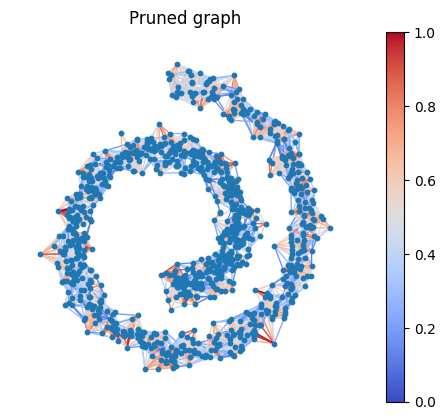

In [14]:
threshold = 0.1

G_pruned = nx.Graph()
preserved_nodes = set()
for i, j, d in orc.G.edges(data=True):
    if d['ricciCurvature'] > threshold:
        G_pruned.add_edge(i, j, weight=d['weight'])
        preserved_nodes.add(i)
        preserved_nodes.add(j)
        # add edge attribute
        G_pruned[i][j]['ricciCurvature'] = d['ricciCurvature']
        
swiss_roll_pruned = swiss_roll[list(preserved_nodes)]
color_pruned = color[list(preserved_nodes)]
print(f'Percentage of edges preserved: {len(G_pruned.edges) / len(G.edges)}')

preserved_orcs = []
for i, j, d in G_pruned.edges(data=True):
    preserved_orcs.append(G_pruned[i][j]['ricciCurvature'])

# plot pruned graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
# get nodelist
nodelist = nx.nodes(G_pruned)
nx.draw(G_pruned, pos=swiss_roll, node_size=10, ax=ax, edge_color=preserved_orcs, edge_cmap=plt.cm.coolwarm, edge_vmin=0, edge_vmax=1)
plt.colorbar(sm)
plt.title("Pruned graph")

Number of components: 1


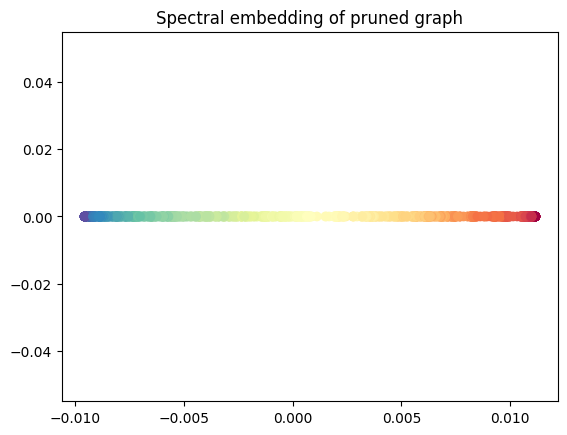

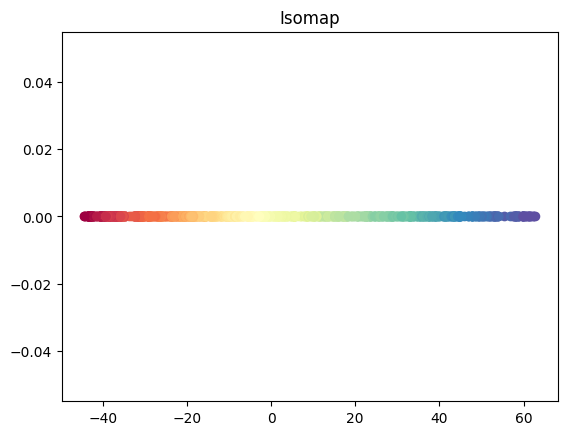

In [15]:
# get number of components
print(f'Number of components: {nx.number_connected_components(G_pruned)}')

# run spectral embedding
knn_pruned = nx.adjacency_matrix(G_pruned).toarray()

se = manifold.SpectralEmbedding(n_components=n_components, affinity='precomputed')
Y = se.fit_transform(knn_pruned)

# plot spectral embedding
fig = plt.figure()
ax = fig.add_subplot(111)
if n_components == 1:
    ax.scatter(Y, np.zeros_like(Y), c=color_pruned[list(G_pruned)], cmap=plt.cm.Spectral)
else:
    ax.scatter(Y[:, 0], Y[:, 1], c=color_pruned[list(G_pruned)], cmap=plt.cm.Spectral)
plt.title("Spectral embedding of pruned graph")
plt.show()

# run isomap with precomputed distances
iso = manifold.Isomap(metric='precomputed', n_components=n_components)
# compute pairwise distances
knn_pruned = np.expand_dims(knn_pruned, axis=0)
# convert edge weight 0 to np.inf
knn_pruned[knn_pruned == 0] = np.inf
distances = gtg.GraphGeodesicDistance(directed=False).fit_transform(knn_pruned)
Y = iso.fit_transform(distances[0])

# plot isomap
fig = plt.figure()
ax = fig.add_subplot(111)
if n_components == 1:
    ax.scatter(Y, np.zeros(n_points), c=color_pruned[list(G_pruned)], cmap=plt.cm.Spectral)
else:
    ax.scatter(Y[:, 0], Y[:, 1], c=color_pruned[list(G_pruned)], cmap=plt.cm.Spectral)
plt.title("Isomap")
plt.show()